<h1 style="color:Green"><b>Potato Disease Classification<b></h1>

In [50]:
import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Flatten,Dense
import matplotlib.pyplot as plt
import numpy as np

In [3]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

In [7]:
for image_batch,labels_batch in dataset.take(3):
  print(image_batch.shape)
  print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]
(32, 256, 256, 3)
[1 0 0 1 1 0 1 0 0 1 0 2 0 1 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1 0 0 0]
(32, 256, 256, 3)
[1 1 1 2 1 0 1 0 1 1 1 1 0 0 1 0 1 0 0 2 2 1 0 0 1 0 1 1 2 0 1 1]


In [8]:
image_batch[1].numpy().astype("uint8")

array([[[116, 105, 113],
        [124, 113, 121],
        [128, 117, 125],
        ...,
        [122, 111, 117],
        [119, 108, 114],
        [109,  98, 104]],

       [[116, 105, 113],
        [122, 111, 119],
        [124, 113, 121],
        ...,
        [121, 110, 116],
        [119, 108, 114],
        [111, 100, 106]],

       [[116, 105, 113],
        [118, 107, 115],
        [117, 106, 114],
        ...,
        [125, 114, 120],
        [124, 113, 119],
        [120, 109, 115]],

       ...,

       [[156, 151, 158],
        [155, 150, 157],
        [154, 149, 156],
        ...,
        [158, 151, 159],
        [156, 149, 157],
        [155, 148, 156]],

       [[149, 144, 151],
        [150, 145, 152],
        [152, 147, 154],
        ...,
        [154, 147, 155],
        [153, 146, 154],
        [152, 145, 153]],

       [[142, 137, 144],
        [146, 141, 148],
        [150, 145, 152],
        ...,
        [150, 143, 151],
        [149, 142, 150],
        [148, 141, 149]]

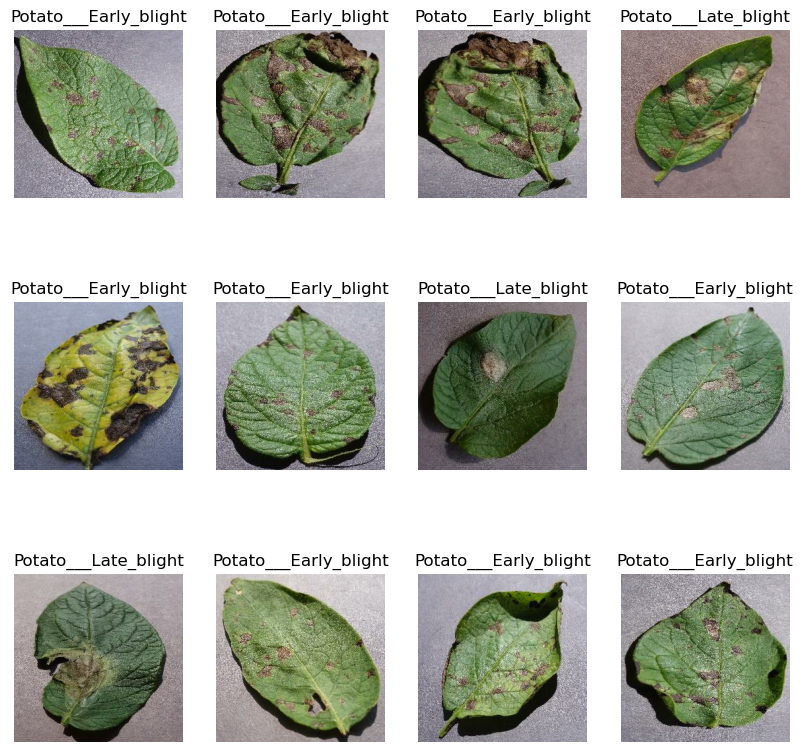

In [9]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [10]:
def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  assert(train_split + test_split + val_split) == 1

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size,seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [12]:
len(train_ds) , len(val_ds), len(test_ds)

(54, 6, 8)

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Resize & Rescale

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255),
])

## Data Augmentation

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [19]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture

In [26]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=len(class_names)

model = models.Sequential([
    Input(batch_shape = input_shape),
    resize_and_rescale,
    
    Conv2D(32, kernel_size = (3, 3), activation = "relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, kernel_size = (3, 3), activation = "relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, kernel_size = (3, 3), activation = "relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, kernel_size = (3, 3), activation = "relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, kernel_size = (3, 3), activation = "relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, kernel_size = (3, 3), activation = "relu"),
    MaxPooling2D((2, 2)),

    Flatten(),
    
    Dense(64, activation = "relu"),
    Dense(n_classes,activation = "softmax"),
])

In [27]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(
    optimizer = "adam",
    loss = "SparseCategoricalCrossentropy",
    metrics = ["accuracy"]
)

In [39]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = 50
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 486ms/step - accuracy: 0.9757 - loss: 0.0604 - val_accuracy: 0.9740 - val_loss: 0.0622
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 502ms/step - accuracy: 0.9763 - loss: 0.0548 - val_accuracy: 0.8646 - val_loss: 0.7225
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 558ms/step - accuracy: 0.9884 - loss: 0.0356 - val_accuracy: 0.9948 - val_loss: 0.0129
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 591ms/step - accuracy: 0.9832 - loss: 0.0511 - val_accuracy: 0.9740 - val_loss: 0.0636
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 576ms/step - accuracy: 0.9676 - loss: 0.0906 - val_accuracy: 0.9844 - val_loss: 0.0993
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 582ms/step - accuracy: 0.9797 - loss: 0.0521 - val_accuracy: 0.9740 - val_loss: 0.0472
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 581ms/step - accuracy: 0.9850 - loss: 0.0494 - val_accuracy: 0.9219 - val_loss: 0.3468
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 581ms/step - accuracy: 0.9919 - loss: 0.0275 - val_accu

In [40]:
scores = model.evaluate(test_ds) 

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - accuracy: 0.9805 - loss: 0.0564


In [41]:
scores

[0.05640304833650589, 0.98046875]

In [42]:
history

In [43]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [44]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [45]:
type(history.history['loss'])

list

In [46]:
len(history.history['loss'])

50

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss'] 

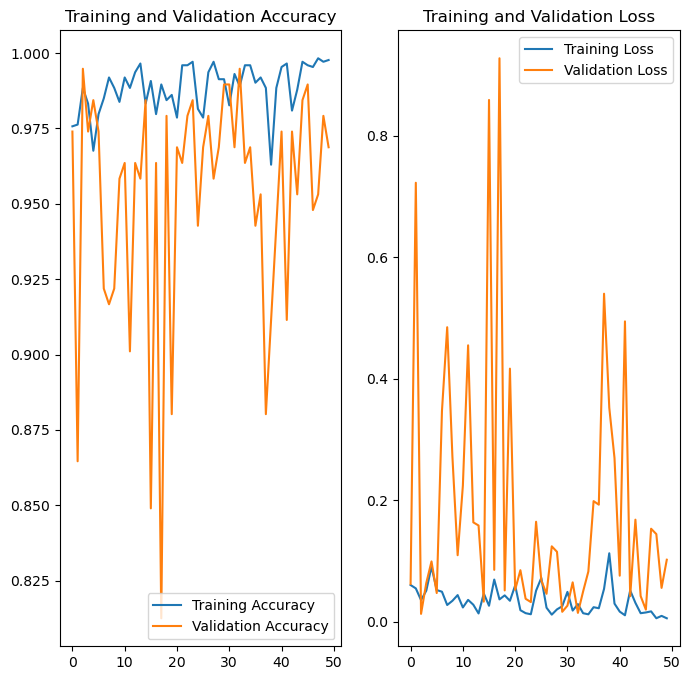

In [49]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
First image to predict
Actual Label :  Potato___Late_blight
Predicted Label :  Potato___Late_blight
Confidence : 100.0


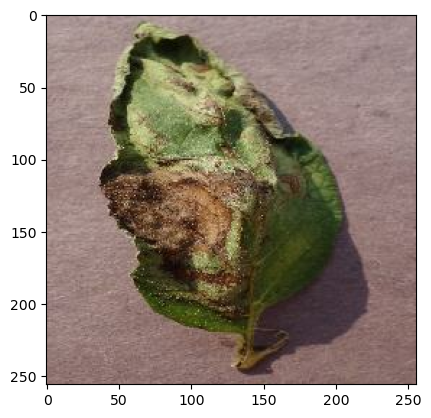

In [59]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    batch_prediction = model.predict(images_batch)
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label : ",class_names[first_label])

    print("Predicted Label : ",class_names[np.argmax(batch_prediction[0])])
    print("Confidence :" , round(100 * (np.max(batch_prediction[0])), 2))

In [62]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    prediction = model.predict(img_array)

    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])),2)

    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


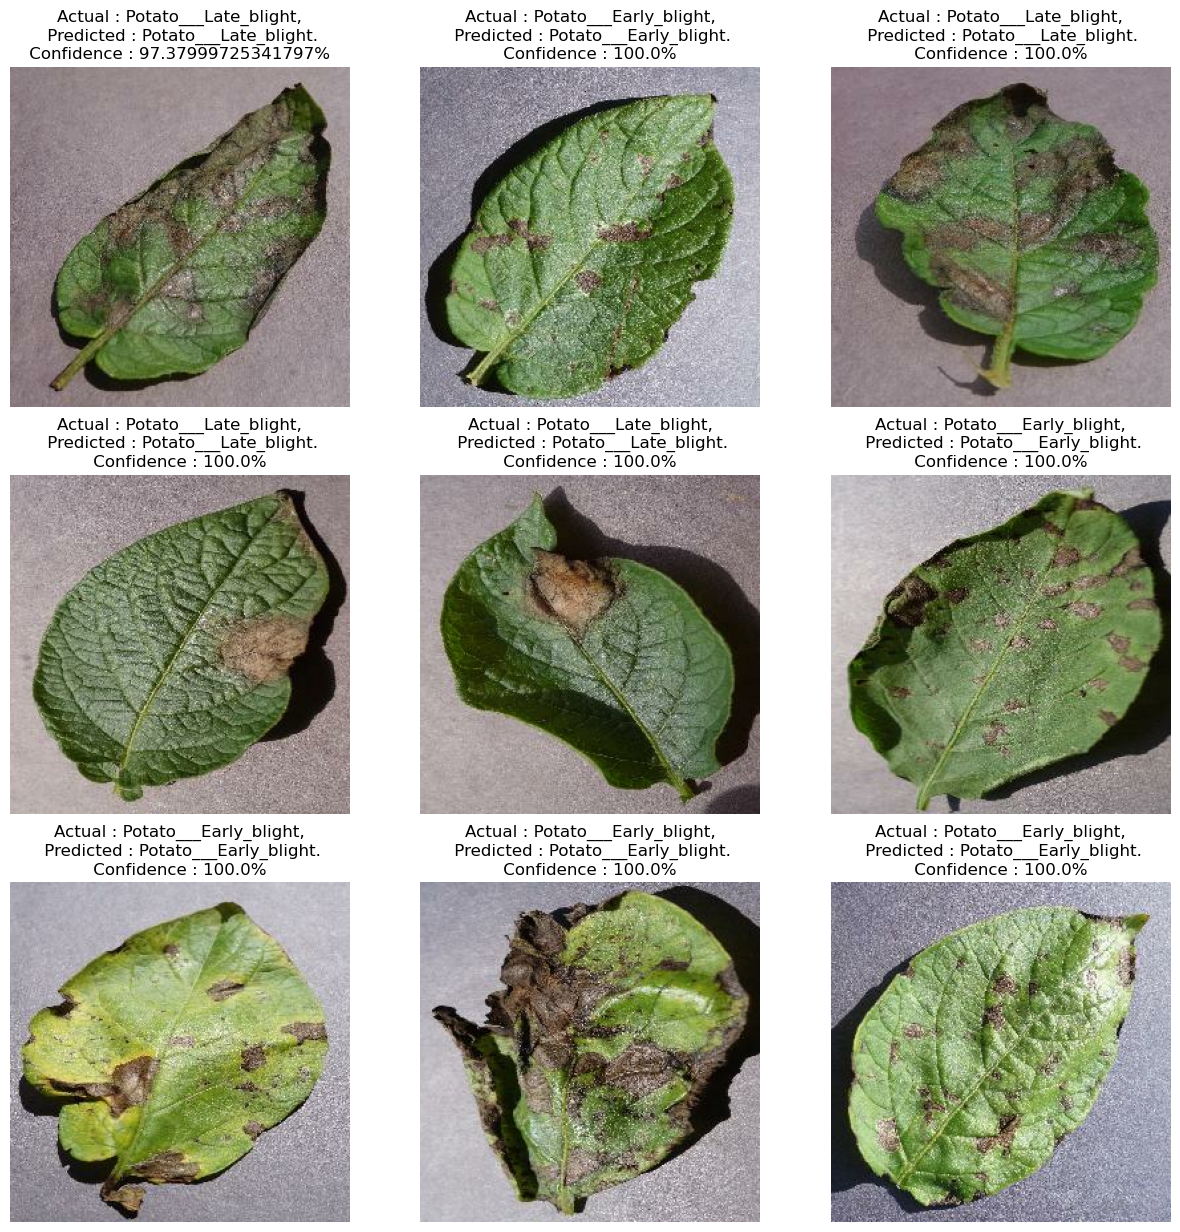

In [68]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class,  confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual : {actual_class},\n Predicted : {predicted_class}.\n Confidence : {confidence}% ")
        plt.axis("off")
plt.show()        

## Save The Model

In [117]:
import os 

base_dir = "./models"
os.makedirs(base_dir,exist_ok = True)

versions = [int(i) for i in os.listdir("./models") if i.isdigit()]
next_version = max(versions +[0]) + 1

save_path = os.path.join(base_dir, str(next_version))
os.makedirs(save_path, exist_ok = True)

model.save(os.path.join(save_path, "model.keras"))
print(f"Model saved in folder :{save_path}")

Model saved in folder :./models\4


In [118]:
os.makedirs("./potatomodels",exist_ok = True)
model.save(f"./potatomodels/Potato.h5")      
